# Lab 1.2 - Clustering Load Profiles

Load profiling is a crucial aspect of energy consumption analysis that involves collecting and analyzing data on the energy usage of a system or building. Clustering, on the other hand, is a machine learning technique used to group similar data points together.

In this exercise session, we will learn how to use Python to cluster load profiles. We will start by exploring what load profiles are, how they are collected and why they are important. Next, we will delve into the theory behind clustering and its applications in load profiling. We will then work through a step-by-step guide to using Python's scikit-learn library to perform load profile clustering.

By the end of this exercise session, you will have a good understanding of load profiles, clustering techniques and how to apply these techniques in Python to perform load profile clustering. You will also be able to interpret the results of the clustering and use them to make informed decisions about energy consumption management. So, let's get started!

### Importing Libraries and Data

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
import numpy as np
from sklearn.cluster import KMeans
import seaborn as sns

df = pd.read_csv("data/LoadTimeSeriesData.csv", parse_dates=['timestamp'])

**Task**: use one of the previous nas replacement methods to fill nas

In [12]:
df['power'].interpolate(method='spline', inplace=True, order=3)

In order to perform load profiles clustering, we need to re-organize our dataset into a MxN matrix where:
* M is the number of days in our dataset
* N is the frequency of our timeseries (i.e. hour)

**Task**: Assign new columns for data and hour

In [13]:
df['date'] = df['timestamp'].dt.date
df['hour'] = df['timestamp'].dt.hour

**Task**: generate the MxN matrix using the new columns.

*hint*: use the pivot function of pandas

In [14]:
df_matrix = df.pivot(index='date', columns='hour', values='power')

**Task**: perfrom clustering using KMeans method. Select a value for K (desired number of clusters). Then extract the cluster labels from the results obtained.

In [15]:
# Perform clustering
K = 5
kmeans = KMeans(n_clusters=K, random_state=0).fit(df_matrix)
labels = kmeans.labels_

c:\Users\SilvioBrandi\VisualStudioProjects\aiis-energy-mllabs\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


**Task**: add the labels to the original dataframe (timeseries) 

In [16]:
# Add the cluster labels to the original dataset
df['cluster'] = np.repeat(labels, 24)

### Centroids

In the context of load profiles clustering, centroids are usually represented as the average load profile of the cluster.

**Task**: evaluate the average profile (i.e. evaluate the mean of power for each cluster and each hour)

In [ ]:
# creating a new DataFrame with the average power for each hour of the day and for each cluster
centroids = df.groupby(['cluster', 'hour'])['power'].mean().reset_index()

**Task**: plot the load profiles for each cluster and the centroid.

*hint*: employ the code of the previous lab

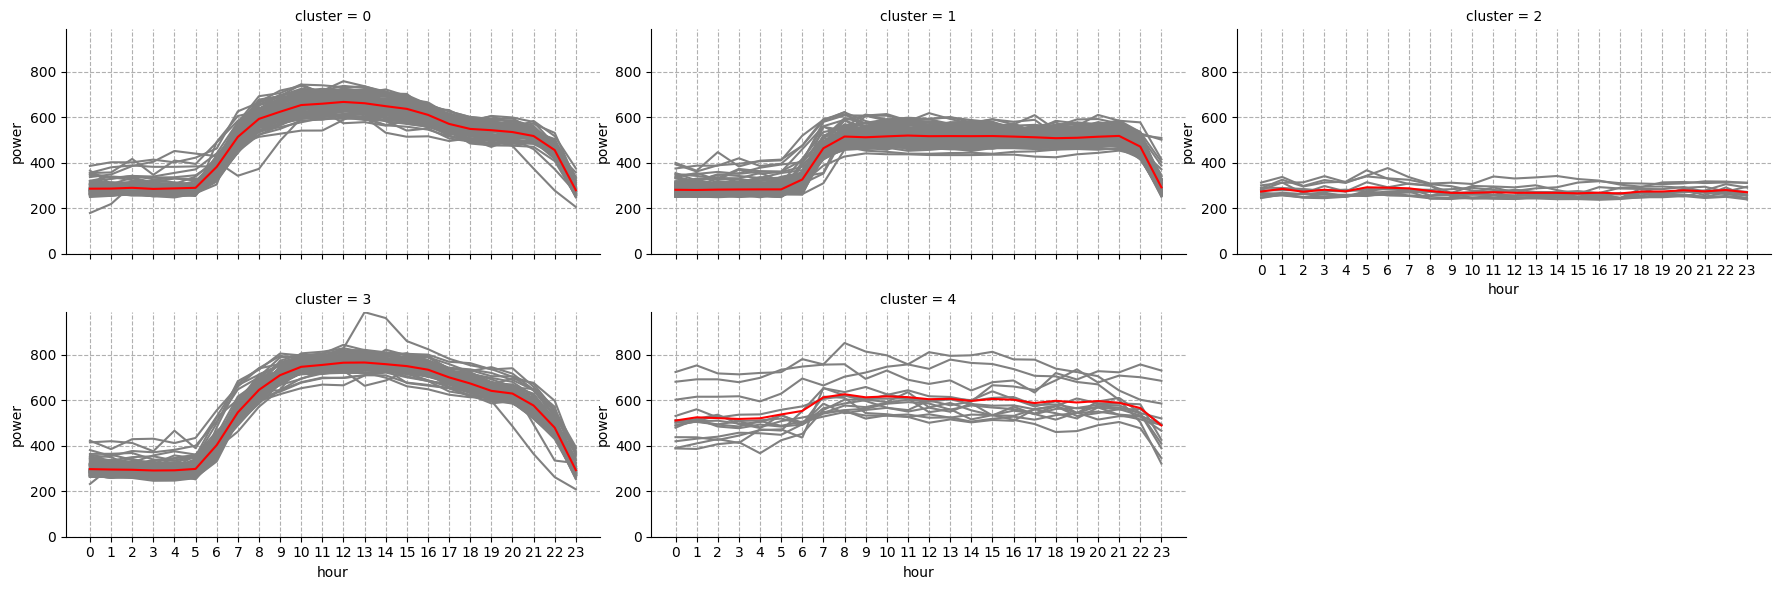

In [21]:
# generating load profiles
g = sns.FacetGrid(data=df, col='cluster', hue='date', col_wrap=3, height=3, aspect=2, sharey=False)
g.map(sns.lineplot, 'hour', 'power', color='gray')

# adding average values
for ax, cluster in zip(g.axes.flatten(), centroids['cluster'].unique()):
    sns.lineplot(x='hour', y='power', data=centroids[centroids['cluster'] == cluster], color='r', ax=ax, label='Profilo medio', legend=False)
    ax.set_ylim(bottom=0, top=df['power'].max())
    ax.set_xticks(range(0, 24))
    ax.grid(True, linestyle='--')

plt.show()

c:\Users\SilvioBrandi\VisualStudioProjects\aiis-energy-mllabs\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


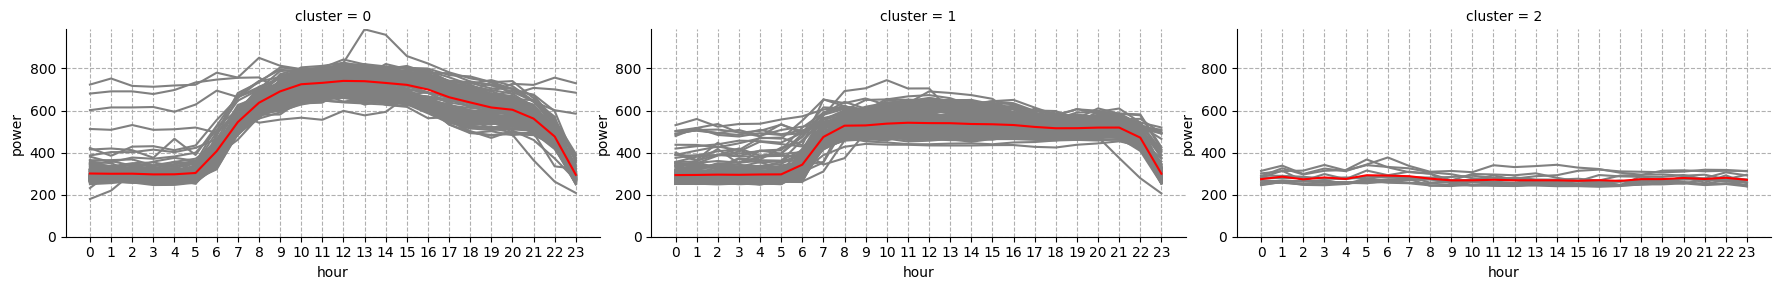

In [23]:
# Perform clustering
K = 3
kmeans = KMeans(n_clusters=K, random_state=0).fit(df_matrix)
labels = kmeans.labels_

# Add the cluster labels to the original dataset
df['cluster'] = np.repeat(labels, 24)

# creating a new DataFrame with the average power for each hour of the day and for each cluster
centroids = df.groupby(['cluster', 'hour'])['power'].mean().reset_index()

# generating load profiles
g = sns.FacetGrid(data=df, col='cluster', hue='date', col_wrap=3, height=3, aspect=2, sharey=False)
g.map(sns.lineplot, 'hour', 'power', color='gray')

# adding average values
for ax, cluster in zip(g.axes.flatten(), centroids['cluster'].unique()):
    sns.lineplot(x='hour', y='power', data=centroids[centroids['cluster'] == cluster], color='r', ax=ax, label='Profilo medio', legend=False)
    ax.set_ylim(bottom=0, top=df['power'].max())
    ax.set_xticks(range(0, 24))
    ax.grid(True, linestyle='--')

plt.show()